In [1]:
import sys
import os
import time
import logging
import argparse
import numpy as np
from datetime import datetime
# from joblib import Parallel, delayed
import h5py
# Set the parent directory. This assumes your notebook is in the project root or a subdirectory.
# Adjust the path as necessary.
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Custom imports from your project
from estimators.statistical_descriptor import Nagler_WS
from utils.dataset_management import parse_pipeline
from utils.dataset_load import shuffle_data, DatasetLoader
from utils.fold_management import FoldManagement
from utils.label_management import LabelManagement
from utils.balance_management import BalanceManagement
from utils.figures import *
from utils.files_management import *
from utils.dask_chunk import *
from utils.SlidingWindowTransformer import *


In [2]:
model = joblib.load("/home/listic/Bureau/cortes_stage/ML-WetSnowSAR_pipeline_stage/pipeline/results/pipeline/run_4/group_0/models/RandomForest_direct/RandomForest_direct_fold2.joblib")
model

/home/listic/miniconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/listic/miniconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/listic/miniconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.1 when using ve

Pipeline(memory='.cache',
         steps=[('BandSelector',
                 BandSelector(bands=[0, 1, 2, 3, 4, 5, 6, 7, 8])),
                ('BandTransformer',
                 BandTransformer(bands=[0, 1, 2, 3], transformations=[])),
                ('Hist_SAR', Hist_SAR()),
                ('RandomForestClassifier',
                 RandomForestClassifier(n_estimators=200,
                                        random_state=RandomState(MT19937) at 0x7E5D5C3D2740))],
         verbose=True)

In [3]:
from osgeo import gdal 
dataset = gdal.Open('/home/listic/Bureau/cortes_stage/ML-WetSnowSAR_pipeline_stage/pipeline/data/validation/Acs_GR_jan2jun21/GRANDES-ROUSSES_20210118.tif')

image_3d = dataset.ReadAsArray()

image_3d = image_3d
image_3d = np.transpose(image_3d, (1, 2, 0))
# image_3d = image_3d[500:2000,:2000,:]
image_3d.shape

(2851, 3900, 9)

In [4]:
# image_3d = np.random.rand(100, 100, 9)

In [5]:
transformer = SlidingWindowTransformer(estimator=model, window_size=15, padding=True, use_predict_proba=True)
result_2d = transformer.transform(image_3d)
print(result_2d.shape)

chunks : (658, 658, 9)


  0%|          | 0/144102 [00:00<?, ?it/s]



  0%|          | 7/144102 [00:00<3:34:01, 11.22it/s]








  0%|          | 21/144102 [00:01<2:22:39, 16.83it/s]









  0%|          | 28/144102 [00:01<1:51:38, 21.51it/s]








  0%|          | 35/144102 [00:01<1:33:39, 25.64it/s]









  0%|          | 49/144102 [00:01<1:00:01, 40.00it/s]









  0%|          | 70/144102 [00:02<35:34, 67.47it/s]  









  0%|          | 112/144102 [00:02<19:11, 125.08it/s]









  0%|          | 196/144102 [00:02<10:07, 236.80it/s]


  0%|          | 252/144102 [00:02<08:18, 288.41it/s]






  0%|          | 308/144102 [00:02<07:26, 322.29it/s]


  0%|          | 364/144102 [00:02<07:59, 299.90it/s]






  0%|          | 420/144102 [00:03<07:55, 302.23it/s]



  0%|          | 476/144102 [00:03<09:19, 256.80it/s]






  0%|          | 532/144102 [00:03<09:29, 252.20it/s]





: 

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
result_2d = result_2d.squeeze()
result_2d.shape
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(result_2d, cmap="viridis", ax=ax[0])
ax[0].set_title('Heatmap of the Resulting 2D Predictions')

sns.heatmap(image_3d[:, :, 4], cmap="viridis", ax=ax[1])
ax[1].set_title('Heatmap of the 3D Image Slice')

plt.show()


In [ ]:
available_memory = psutil.virtual_memory().available
num_cpus = psutil.cpu_count()

element_size = image_3d.dtype.itemsize
element_size = element_size * image_3d.shape[2] 

chunk_memory_size = available_memory / (num_cpus * 200)
chunk_elements = chunk_memory_size // element_size
chunk_side_length = int(np.sqrt(chunk_elements))

chunk_side_length = max(chunk_side_length, 15)

chunks = (chunk_side_length, chunk_side_length, image_3d.shape[2])

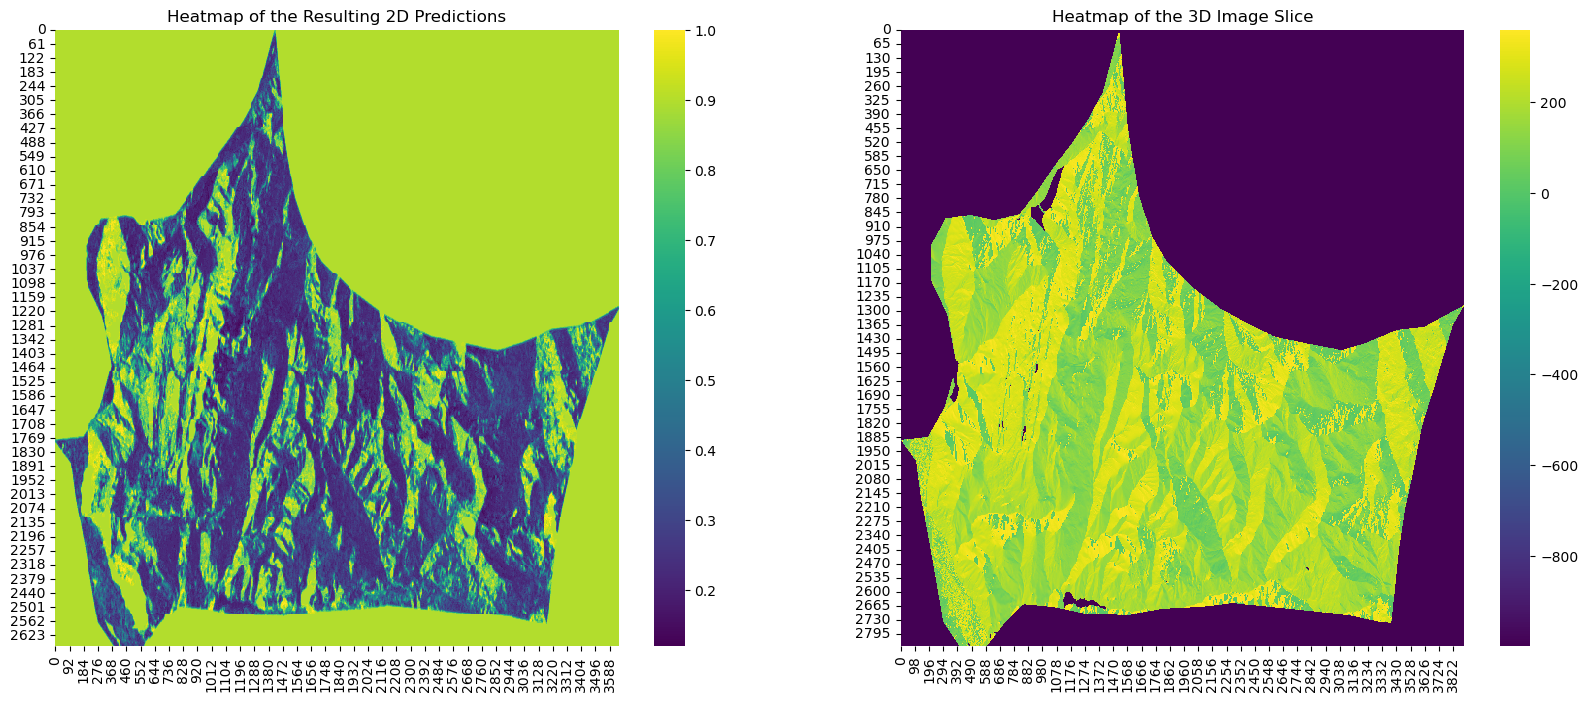

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns
map_generated = open_pkl("/home/listic/Bureau/cortes_stage/ML-WetSnowSAR_pipeline_stage/pipeline/results/pipeline/run_6/map.pkl")
map_generated = map_generated.squeeze()
map_generated.shape
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(map_generated, cmap="viridis", ax=ax[0])
ax[0].set_title('Heatmap of the Resulting 2D Predictions')

sns.heatmap(image_3d[:, :, 4], cmap="viridis", ax=ax[1])
ax[1].set_title('Heatmap of the 3D Image Slice')

plt.show()
